### 备注

#（1）【目的】：
#（2）【Author】：shasha.mao
#（3）【日期】：2020/11/16
#（4）【数据】：
#（5）【路径】：
#（6）【备注】：https://zhuanlan.zhihu.com/p/60648709
#（6）【备注】：https://zhuanlan.zhihu.com/p/62218680
#（6）【备注】：https://zhuanlan.zhihu.com/p/60648709
#（7）【更改】：初版 2021/03/03

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import util
import json
import os
import sys
import tqdm
import time
import datetime
from statsmodels.tsa.arima_model import ARIMA

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF

# 参考模板导入
from __future__ import print_function
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings("ignore")

In [2]:
print(datetime.datetime.now())
start = time.time()

2021-03-04 11:24:23.347946


### 数据导入

In [3]:
user_balance = pd.read_csv(r'.\data\Purchase Redemption Data\user_balance_table.csv', parse_dates = ['report_date'])
timeGroup = user_balance.groupby(['report_date'])
purchaseRedeemTotal = timeGroup['total_purchase_amt', 'total_redeem_amt'].sum()
purchaseRedeemTotal.head()

,total_purchase_amt,total_redeem_amt
report_date,,
2013-07-01,32488348,5525022
2013-07-02,29037390,2554548
2013-07-03,27270770,5953867
2013-07-04,18321185,6410729
2013-07-05,11648749,2763587


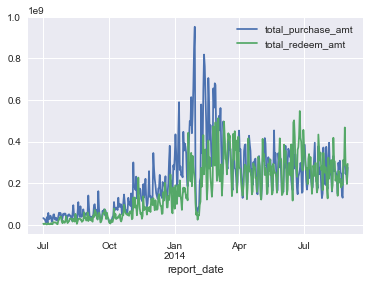

In [4]:
purchaseRedeemTotal.plot()

### 切分训练集和测试集

014, 2, 15

In [5]:
purchase_train = purchaseRedeemTotal.loc[datetime.date(2014, 4, 1):datetime.date(2014, 7, 31), :]
purchase_test = purchaseRedeemTotal.loc[datetime.date(2014, 8, 1):, :]

### ARIMA模型尝试

#### 作图

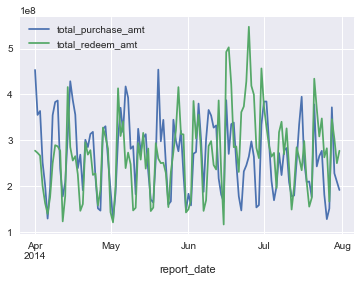

In [6]:
# 因为我们只要预测申购量和赎回量，取出每天两者的数据对其进行时间序列的拟合回归。
purchase_train.plot()
dta=purchase_train['total_purchase_amt'].astype("float")

#### 原序列的平稳性 

#增广迪基-福勒检验(Augmented Dickey-Fuller test),简称ADF检验。简而言之，单位根存在则预示存在驱动AAPL的潜在趋势，从而我们可以提取模式并用于预测。ADF原假设：存在单位根-->非平稳序列
#但是它只有小于1%水平下才能认为是及其显著的拒绝原假设。
#接收原假设，申购量时间序列为非平稳序列

In [7]:
sm.tsa.stattools.adfuller(dta)

(-2.0639747511769895,
 0.2592449964335155,
 13,
 108,
 {'1%': -3.4924012594942333,
  '5%': -2.8886968193364835,
  '10%': -2.5812552709190673},
 4191.005978668395)

#### 一阶差分序列的平稳性

#T假设检验值：－7.94
#假设检验结果p-value，接近于0
#－7.94小于-3.44，拒绝原假设，且p值无限小于0，一阶差分是平稳序列

In [8]:
sm.tsa.stattools.adfuller(dta.diff(1).dropna())

(-6.506628772152375,
 1.1269525633397093e-08,
 12,
 108,
 {'1%': -3.4924012594942333,
  '5%': -2.8886968193364835,
  '10%': -2.5812552709190673},
 4156.074758015524)

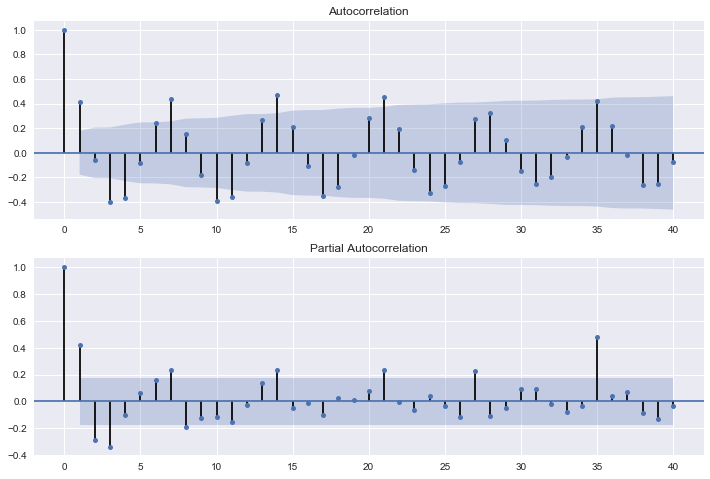

In [9]:
#检验平稳
diff1= dta.diff(1)

fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta,lags=40,ax=ax2)

从一阶差分序列的自相关系数和偏自相关系数来看，没有发现明显的拖尾和截尾，这说明对于这样的序列，并不适合用ARIMA模型来拟合。这里我们将先通过对时间序列分解（STL），再采用 ARIMA 模型来拟合趋势序列与残差序列。

### 时间序列分解 

#### STL

时间序列特性：趋势、周期变化、序列相关性、随机噪声

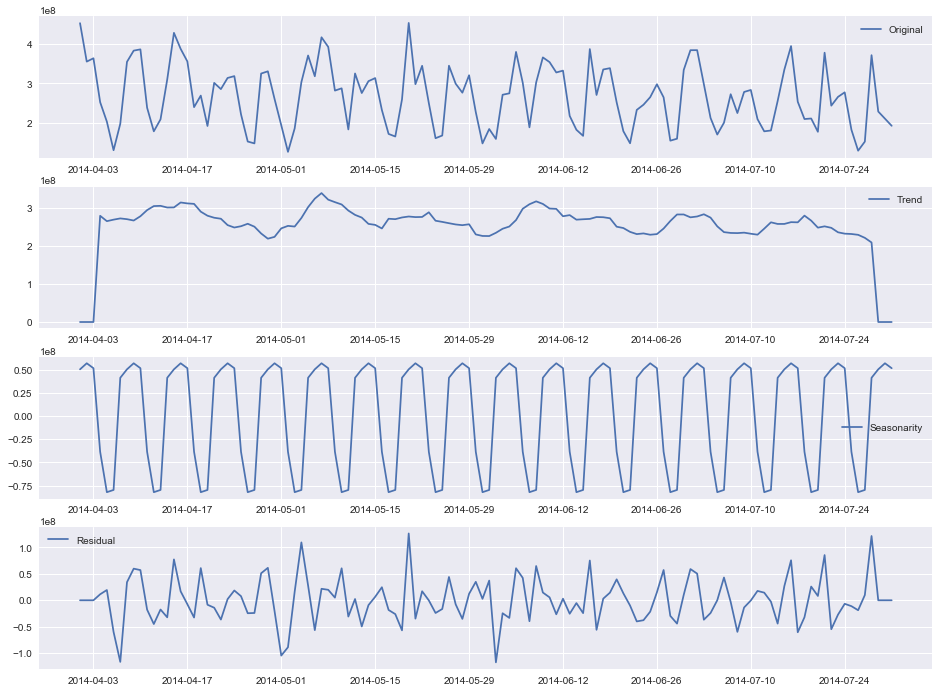

In [10]:
decomposition = seasonal_decompose(dta)
trend = decomposition.trend.fillna(0)
seasonal = decomposition.seasonal.fillna(0)
residual = decomposition.resid.fillna(0)

# 原始
plt.figure(figsize=(16, 12))
plt.subplot(411)
plt.plot(dta, label='Original')
plt.legend(loc='best')

# 趋势序列
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)

# 周期序列
plt.plot(seasonal, label='Seasonarity')
plt.legend(loc='best')
plt.subplot(414)

# 残差序列
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.show()

从上图中可以看到，原序列有明显的周期性，而且是以七天为一个周期（可以将具体的数值打印出来）。因此我们只对趋势序列和残差序列去拟合，同时认为这样的周期性会延伸至2014-08-01~2014-08-10的测试集上。下面将介绍对趋势序列、残差序列的拟合过程。

#### 趋势序列和残差序列 ADF检验

In [11]:
sm.tsa.stattools.adfuller(trend)

(-3.2368487584485877,
 0.017948383665881536,
 0,
 121,
 {'1%': -3.485585145896754,
  '5%': -2.885738566292665,
  '10%': -2.5796759080663887},
 3971.5751227480287)

In [12]:
sm.tsa.stattools.adfuller(residual)

(-6.2902121046483455,
 3.61472775679644e-08,
 8,
 113,
 {'1%': -3.489589552580676,
  '5%': -2.887477210140433,
  '10%': -2.580604145195395},
 4080.577975834708)

趋势序列和残差序列都满足平稳性，因此不需要再进行差分了

#### 趋势序列－自相关系数和偏自相关系数 

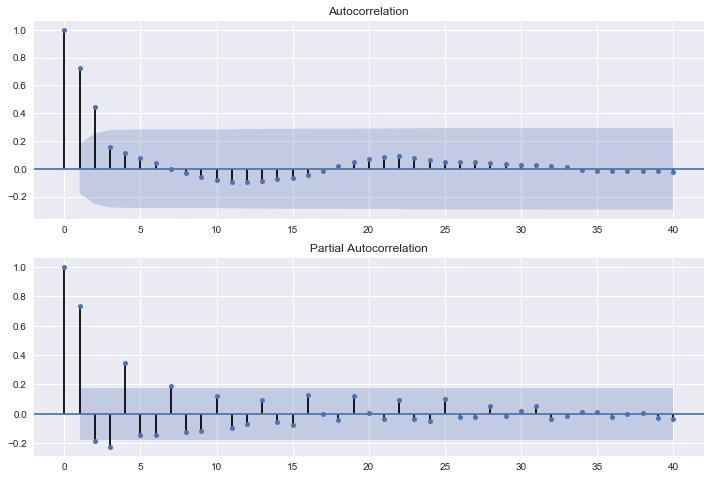

In [13]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(trend,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(trend,lags=40,ax=ax2)

#### 残差序列－自相关系数和偏自相关系数 

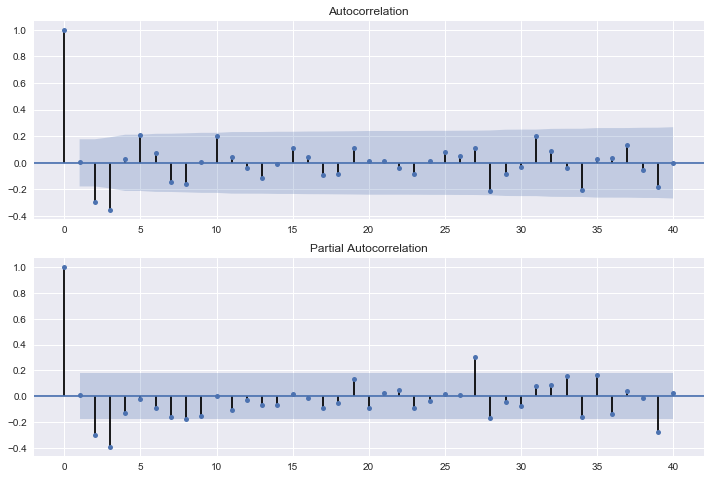

In [14]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residual,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residual,lags=40,ax=ax2)

### 通过AIC和BIC准则确定模型阶数

In [18]:
sm.tsa.arma_order_select_ic?

In [20]:
# 趋势队列的AIC和BIC
trend_evaluate = sm.tsa.arma_order_select_ic(trend, ic=['aic', 'bic'], trend='nc', max_ar=4,max_ma=4)
print('trend AIC', trend_evaluate.aic_min_order)
print('trend BIC', trend_evaluate.bic_min_order)

# 残差队列的AIC和BIC
residual_evaluate = sm.tsa.arma_order_select_ic(residual, ic=['aic', 'bic'], trend='nc', max_ar=4,max_ma=4)
print('residual AIC', residual_evaluate.aic_min_order)
print('residual BIC', residual_evaluate.bic_min_order)

trend AIC (1, 0)
trend BIC (1, 0)
residual AIC (2, 1)
residual BIC (2, 1)


### 模型训练 

In [24]:
ARIMA?

In [29]:
# p,d,q
trend_model = ARIMA(trend, order=(1, 0, 0))
trend_model.fit()
trend_predict_seq = trend_model.predict(start='2014-08-01', end='2014-08-31', dynamic=True)

TypeError: predict() missing 1 required positional argument: 'params'

In [30]:
trend_model.predict?

### 数据导入

In [16]:
print("本次运行总共耗时%.1f秒" % (time.time() - start))

本次运行总共耗时31.5秒
